In [1]:
import os
from pathlib import Path
import cv2
import torchvision.transforms as transforms
import torch
import gdown

from lseg.utils.lseg_utils import get_lseg_feat
from lseg.models.lseg_encnet import LSegEncNet

/home/yzf/conda/envs/vlmaps-mini/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def get_checkpoint_path():
    checkpoint_dir = Path(os.path.abspath('')) / "checkpoints"
    checkpoint_path = checkpoint_dir / "demo_e200.ckpt"
    os.makedirs(checkpoint_dir, exist_ok=True)
    if not checkpoint_path.exists():
        print("Downloading LSeg checkpoint...")
        # the checkpoint is from official LSeg github repo
        # https://github.com/isl-org/lang-seg
        checkpoint_url = "https://drive.google.com/u/0/uc?id=1ayk6NXURI_vIPlym16f_RG3ffxBWHxvb"
        gdown.download(checkpoint_url, output=str(checkpoint_path))
    return checkpoint_path

def _init_lseg():
    crop_size = 192  # 480
    base_size = 400  # 520
    lseg_model = LSegEncNet("", arch_option=0, block_depth=0, activation="lrelu", crop_size=crop_size)
    
    model_state_dict = lseg_model.state_dict()

    pretrained_state_dict = torch.load(get_checkpoint_path(), map_location=device, weights_only=False)
    pretrained_state_dict = {k.lstrip("net."): v for k, v in pretrained_state_dict["state_dict"].items()}
    model_state_dict.update(pretrained_state_dict)
    lseg_model.load_state_dict(pretrained_state_dict)

    lseg_model.eval()
    lseg_model = lseg_model.to(device)

    norm_mean = [0.5, 0.5, 0.5]
    norm_std = [0.5, 0.5, 0.5]
    lseg_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )
    return lseg_model, lseg_transform, crop_size, base_size, norm_mean, norm_std

In [3]:
lseg_model, lseg_transform, crop_size, base_size, norm_mean, norm_std = _init_lseg()

In [4]:
img = '/home/yzf/图片/xing.jpg'
bgr = cv2.imread(str(img))
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
pix_feats = get_lseg_feat(
    lseg_model, rgb, ['flower'], lseg_transform, device, crop_size, base_size, norm_mean, norm_std
)
pix_feats

array([[[[ 5.15136719e-01,  5.24851203e-01,  5.34565687e-01, ...,
           5.20694435e-01,  5.15837193e-01,  5.09936869e-01],
         [ 5.20236850e-01,  5.32246470e-01,  5.44256091e-01, ...,
           5.36419451e-01,  5.34098923e-01,  5.30735314e-01],
         [ 5.25336921e-01,  5.39641678e-01,  5.53946435e-01, ...,
           5.52144468e-01,  5.52360654e-01,  5.51533759e-01],
         ...,
         [-4.86622095e-01, -5.10498941e-01, -5.34375727e-01, ...,
          -5.58147967e-01, -5.50479293e-01, -5.43538570e-01],
         [-4.82802868e-01, -5.05843043e-01, -5.28883159e-01, ...,
          -5.56021392e-01, -5.48247218e-01, -5.41340709e-01],
         [-4.72116917e-01, -4.94190723e-01, -5.16264498e-01, ...,
          -5.45800805e-01, -5.38872242e-01, -5.32841802e-01]],

        [[ 2.00073242e-01,  1.98980361e-01,  1.97887480e-01, ...,
           1.63454711e-01,  1.66247621e-01,  1.69086561e-01],
         [ 1.91815928e-01,  1.89243302e-01,  1.86670676e-01, ...,
           1.57033160e

In [17]:
import clip
window = clip.tokenize("persons").to(device)
window_vec = lseg_model.clip_pretrained.encode_text(window)
window_vec = window_vec.type(torch.float32)
window_vec.dtype

torch.float32

In [18]:
pix_feats = torch.tensor(pix_feats).to(device)
pix_feats.dtype

/tmp/ipykernel_367276/1998293919.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pix_feats = torch.tensor(pix_feats).to(device)


torch.float32

In [19]:
pix_feats /= pix_feats.norm(dim=1, keepdim=True)

In [20]:
map = torch.einsum('pdmn,qd->pqmn', pix_feats, window_vec).detach().cpu()

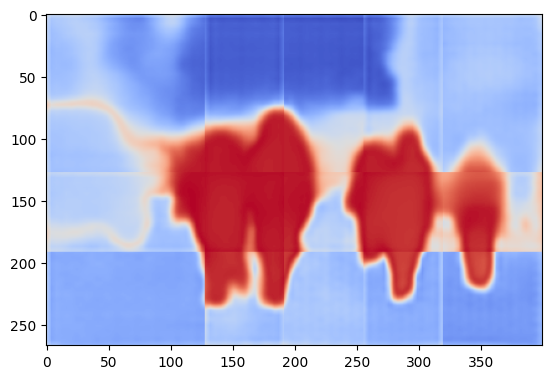

In [21]:
import matplotlib.pyplot as plt
plt.imshow(map[0, 0].numpy(), cmap='coolwarm')

In [22]:
pix_feats.norm(dim=1)

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]],
       device='cuda:0')